In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

import pandas as pd
import os

import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


## Notes


Priority:

- Use full dataset
- CNN model (custom defined)
- Trim off outliers (price more than a particular threshold)
- Scale down target column or scale down loss (custom loss)
- Hybrid model - Definitely do this
- Check out data generator parameters

Others:

- Learning rate
- Change activation function to maybe linear?
- Optimizers
- Unfreezing some of the lower layers
- More epochs - upto 50?
- Fewer units in dense layer
- Higher batch size (8,16)

In [3]:
# Load the training and validation dataset and labels

train_label_df = pd.read_excel("dataset_splits/cleaned_train_data.xlsx")
test_label_df = pd.read_excel("dataset_splits/cleaned_test_data.xlsx")

In [4]:
train_label_df.columns[:30]

Index(['pictureid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'roomcnt', 'yearbuilt', 'numberofstories', 'taxvaluedollarcnt',
       'assessmentyear', 'propertycountylandusecode_1',
       'propertycountylandusecode_34', 'propertycountylandusecode_38',
       'propertycountylandusecode_96', 'propertycountylandusecode_122',
       'propertycountylandusecode_135', 'propertylandusetypeid_246',
       'propertylandusetypeid_247', 'propertylandusetypeid_248',
       'propertylandusetypeid_261', 'propertylandusetypeid_266',
       'regionidcity_5465.0', 'regionidcity_6285.0', 'regionidcity_8384.0'],
      dtype='object')

In [5]:
train_label_df.head()

,pictureid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,...,censustractandblock_60590200000000,censustractandblock_60590300000000,censustractandblock_60590400000000,censustractandblock_60590500000000,censustractandblock_60590600000000,censustractandblock_60590700000000,censustractandblock_60590800000000,censustractandblock_60590900000000,censustractandblock_60591000000000,censustractandblock_60591100000000
0,0,5.5,5,5.5,5042,5,4,988,33509223,-117672518,...,0,0,1,0,0,0,0,0,0,0
1,1,1.5,3,1.5,1695,1,1,360,33820017,-117971956,...,0,0,0,0,0,0,0,1,0,0
2,2,2.0,4,2.0,1460,2,2,456,33677514,-117954806,...,0,0,0,0,0,0,0,0,1,0
3,3,1.0,2,1.0,1296,1,1,288,33744721,-117863804,...,0,0,0,0,0,0,1,0,0,0
4,4,2.0,3,2.0,1397,2,1,360,33756060,-117875860,...,0,0,0,0,0,0,1,0,0,0


In [6]:
train_label_df["taxvaluedollarcnt"].describe()

count    1.499900e+04
mean     5.236140e+05
std      6.055467e+05
min      1.855600e+04
25%      2.456040e+05
50%      4.052130e+05
75%      6.295750e+05
max      2.164466e+07
Name: taxvaluedollarcnt, dtype: float64

In [7]:
train_label_df["target_scaled_down"] = train_label_df["taxvaluedollarcnt"]/1e5
test_label_df["target_scaled_down"] = test_label_df["taxvaluedollarcnt"]/1e5

In [8]:
train_label_df["target_scaled_down"][:10]

0    19.34378
1     0.74865
2     2.47381
3     1.89652
4     2.65259
5     4.19110
6     2.95834
7     7.03539
8     3.29780
9     1.28322
Name: target_scaled_down, dtype: float64

In [9]:
train_label_df["target_scaled_down"].max()

216.44655

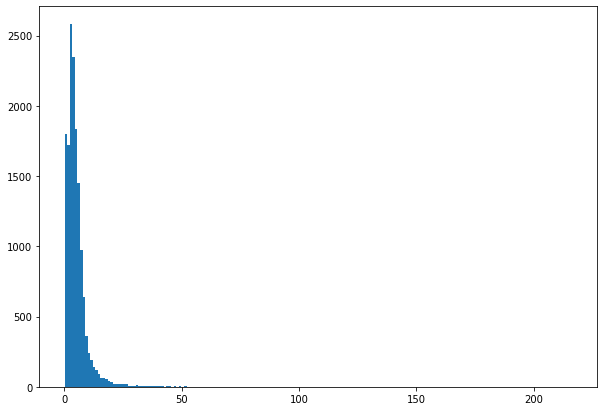

In [10]:

from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(train_label_df["target_scaled_down"], bins = 200)

plt.show()

In [11]:
# Pick threshold to cut off outliers

threshold_value_saved = np.percentile(np.array(train_label_df["target_scaled_down"]), 99)
print(threshold_value_saved)

26.647402400000004


In [12]:
# 10,000,000

In [13]:
# Removing outliers
train_label_df = train_label_df.loc[train_label_df["target_scaled_down"] < threshold_value_saved]
test_label_df = test_label_df.loc[test_label_df["target_scaled_down"] < threshold_value_saved]

In [14]:
print(f"Train df: {len(train_label_df)}, test df: {len(test_label_df)}")

Train df: 14849, test df: 4955


In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    #horizontal_flip = None, 
    #fill_mode = "nearest", 
    #zoom_range = 2, 
    #width_shift_range = None, 
    #height_shift_range = None,
    #rotation_range=None
) 

In [16]:
train_label_df["picturepath"] = train_label_df["pictureid"].astype(str).apply(lambda x: f"pic_{x}.png")

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_label_df, 
    directory = "dataset_splits/all_data_pics/train_data_pics/", 
    x_col = "picturepath", 
    y_col="target_scaled_down", 
    class_mode = "raw", 
    target_size= (400, 400), 
    batch_size = 4
)

Found 14849 validated image filenames.


In [18]:
valid_datagen = ImageDataGenerator(
    rescale = 1./255, 
    #horizontal_flip = None, 
    #fill_mode = "nearest", 
    #zoom_range = 2, 
    #width_shift_range = None, 
    #height_shift_range = None,
    #rotation_range=None
) 

In [19]:
test_label_df["picturepath"] = test_label_df["pictureid"].astype(str).apply(lambda x: f"pic_{x}.png")

In [20]:
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = test_label_df, 
    directory = "dataset_splits/all_data_pics/test_data_pics/", 
    x_col = "picturepath", 
    y_col="target_scaled_down", 
    class_mode = "raw", 
    target_size= (400, 400), 
    batch_size = 4
)

Found 4955 validated image filenames.


### InceptionV3 model

In [21]:
# create the base pre-trained model
base_model = InceptionV3(
    input_shape = ( 400, 400, 3), 
    weights='imagenet', 
    include_top=False
)
    
# add a global spatial average pooling layer
x = layers.Flatten()(base_model.output)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a linear output layer
prediction = Dense(1, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=prediction)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-9)

# compile the model (should be done *after* setting layers to non trainable)
model.compile(
    optimizer=optimizer,#'rmsprop' , 
    loss='mean_absolute_error', 
    metrics = [tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None),
               tf.keras.metrics.MeanAbsolutePercentageError(name='mean_absolute_percentage_error', dtype=None)],
) #'rmsprop'

In [22]:
checkpoint_path = "InceptionV3_checkpoints/v2.0.0/checkpoint.hdf5"

In [23]:
# # Load model from checkpoint
# try: 
#     print('** trying to load latest checkpoint')
#     model.load_weights( checkpoint_path )
#     print('** loaded latest checkpoint')
# except OSError:
#     print('** loading model from scratch')

In [24]:
# If steps per epoch is 250, in 2 epochs model trains over 250*2*4 = 2000 examples, 
# i.e. 1 pass over the whole training dataset

In [25]:
checkpoint_dir = "InceptionV3_checkpoints/v2.0.0"

In [26]:
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [27]:
# Train
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=15,
    steps_per_epoch=250,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint( 
            filepath = f'{checkpoint_dir}/checkpoint.hdf5',
            save_weights_only = True, 
            verbose = 1, 
            save_freq = 3000, # Save every 2000 batches/steps
        ),
        #tf.keras.callbacks.EarlyStopping( monitor='loss', patience=3 ),
    ],
    verbose=1
)

Epoch 1/15
250/250 [==============================] - 57s 205ms/step - loss: 3.5083 - mean_squared_error: 25.5536 - mean_absolute_percentage_error: 71.1416 - val_loss: 3.2688 - val_mean_squared_error: 23.1401 - val_mean_absolute_percentage_error: 68.8846
Epoch 2/15
250/250 [==============================] - 44s 176ms/step - loss: 3.2973 - mean_squared_error: 23.0332 - mean_absolute_percentage_error: 71.2353 - val_loss: 3.1780 - val_mean_squared_error: 22.2694 - val_mean_absolute_percentage_error: 69.2081
Epoch 3/15
250/250 [==============================] - 44s 177ms/step - loss: 3.1704 - mean_squared_error: 21.0371 - mean_absolute_percentage_error: 71.2775 - val_loss: 3.0986 - val_mean_squared_error: 21.4965 - val_mean_absolute_percentage_error: 69.8064
Epoch 4/15
250/250 [==============================] - 44s 178ms/step - loss: 3.2426 - mean_squared_error: 23.6669 - mean_absolute_percentage_error: 72.4253 - val_loss: 3.0271 - val_mean_squared_error: 20.7938 - val_mean_absolute_percen

In [28]:
history_df = pd.DataFrame(history.history) 

In [29]:
# Plot utility
def plot_graphs(history_object_df, string):
  plt.plot(history_object_df[string])

  if "val_loss" in history_object_df.columns:
    plt.plot(history_object_df['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

  else:
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

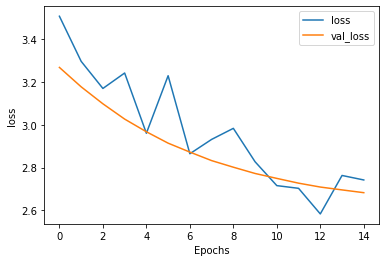

In [30]:
# # rmsprop 10 epochs, 4 batch size
plot_graphs(history_df, "loss")